# Comprehensive Qubit Spectroscopy Demo

This notebook demonstrates all three types of qubit spectroscopy experiments available in LeeQ:

1. **QubitSpectroscopyFrequency** - Single-tone frequency sweep
2. **QubitSpectroscopyAmplitudeFrequency** - 2D amplitude-frequency sweep
3. **TwoToneQubitSpectroscopy** - Dual frequency sweep with two simultaneous tones

Each technique provides unique insights into qubit properties:
- Frequency sweeps identify resonance frequencies
- Amplitude sweeps reveal power broadening and saturation
- Two-tone spectroscopy probes multi-photon transitions and coupling

## Setup: Import Libraries and Configure Environment

In [1]:
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from leeq.experiments.experiments import ExperimentManager
from leeq.experiments.builtin.basic.calibrations.qubit_spectroscopy import (
    QubitSpectroscopyFrequency,
    QubitSpectroscopyAmplitudeFrequency
)
from leeq.experiments.builtin.basic.calibrations.two_tone_spectroscopy import TwoToneQubitSpectroscopy
from leeq.core.elements.built_in.qudit_transmon import TransmonElement
from leeq.setups.built_in.setup_simulation_high_level import HighLevelSimulationSetup
from leeq.theory.simulation.numpy.rotated_frame_simulator import VirtualTransmon
from leeq.chronicle import Chronicle

# Start logging
Chronicle().start_log()
print("Environment configured successfully")

[2025-08-22 10:13:07] [INFO] [leeq.chronicle.chronicle] Log started at log/coxious/2025-08/2025-08-22/10.13.07
[2025-08-22 10:13:07] [INFO] [leeq.chronicle.chronicle] Log started at log/coxious/2025-08/2025-08-22/10.13.07


Environment configured successfully


## Setup: Create Virtual Qubits and Simulation Environment

In [2]:
# Clear any existing setups
manager = ExperimentManager()
manager.clear_setups()

# Create virtual transmons for simulation
# We need separate instances for each channel
virtual_transmon1 = VirtualTransmon(
    name="VQubit1",
    qubit_frequency=5000.0,  # MHz - f01 transition
    anharmonicity=-200.0,    # MHz
    t1=50,                   # us
    t2=25,                   # us
    readout_frequency=9500.0, # MHz
    quiescent_state_distribution=np.array([0.9, 0.08, 0.02, 0.0])
)

virtual_transmon2 = VirtualTransmon(
    name="VQubit2",
    qubit_frequency=4800.0,  # MHz - f12 transition (f01 - anharmonicity)
    anharmonicity=-200.0,
    t1=50,
    t2=25,
    readout_frequency=9500.0,
    quiescent_state_distribution=np.array([0.9, 0.08, 0.02, 0.0])
)

virtual_transmon3 = VirtualTransmon(
    name="VQubit3",
    qubit_frequency=5000.0,  # For readout channel
    anharmonicity=-200.0,
    t1=50,
    t2=25,
    readout_frequency=9500.0,
    quiescent_state_distribution=np.array([0.9, 0.08, 0.02, 0.0])
)

# Setup high-level simulation
setup = HighLevelSimulationSetup(
    name='ComprehensiveSpectroscopyDemo',
    virtual_qubits={
        1: virtual_transmon1,  # Channel 1 (f01)
        2: virtual_transmon2,  # Channel 2 (f12) 
        3: virtual_transmon3   # Channel 3 (readout)
    }
)

# Optional: Set coupling between qubits for crosstalk simulation
setup.set_coupling_strength_by_qubit(virtual_transmon1, virtual_transmon2, coupling_strength=2.0)

manager.register_setup(setup)
print("Virtual qubits created and simulation setup registered")

Virtual qubits created and simulation setup registered


## Setup: Configure Qubit Element

In [3]:
# Define qubit configuration with drive and measurement parameters
qubit_config = {
    'lpb_collections': {
        'f01': {
            'type': 'SimpleDriveCollection',
            'freq': 5000.0,  # Initial guess for f01 frequency
            'channel': 1,
            'shape': 'blackman_drag',
            'amp': 0.5,
            'phase': 0.,
            'width': 0.05,
            'alpha': 500,
            'trunc': 1.2
        },
        'f12': {
            'type': 'SimpleDriveCollection',
            'freq': 4800.0,  # Initial guess for f12 frequency
            'channel': 2,
            'shape': 'blackman_drag',
            'amp': 0.1,
            'phase': 0.,
            'width': 0.025,
            'alpha': 425,
            'trunc': 1.2
        }
    },
    'measurement_primitives': {
        '0': {
            'type': 'SimpleDispersiveMeasurement',
            'freq': 9500.0,
            'channel': 3,
            'shape': 'square',
            'amp': 0.15,
            'phase': 0.,
            'width': 1,
            'trunc': 1.2,
            'distinguishable_states': [0, 1]
        }
    }
}

# Create qubit element
qubit = TransmonElement(name='Q1', parameters=qubit_config)
print(f"Created qubit element: {qubit.hrid}")
print(f"Initial f01 frequency: {qubit_config['lpb_collections']['f01']['freq']} MHz")
print(f"Initial f12 frequency: {qubit_config['lpb_collections']['f12']['freq']} MHz")

Created qubit element: Q1
Initial f01 frequency: 5000.0 MHz
Initial f12 frequency: 4800.0 MHz


## Part 1: Single-Tone Frequency Spectroscopy

First, we perform a basic frequency sweep to identify the qubit resonance frequency.
This is typically the first characterization step for a new qubit.

Running single-tone frequency spectroscopy...


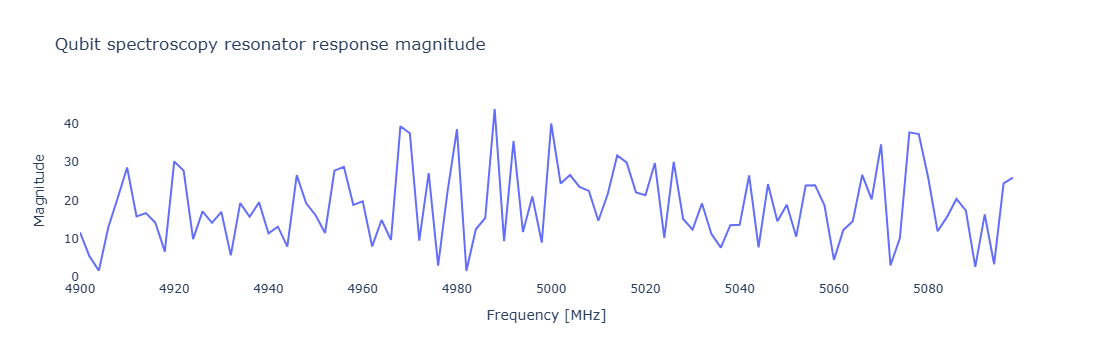

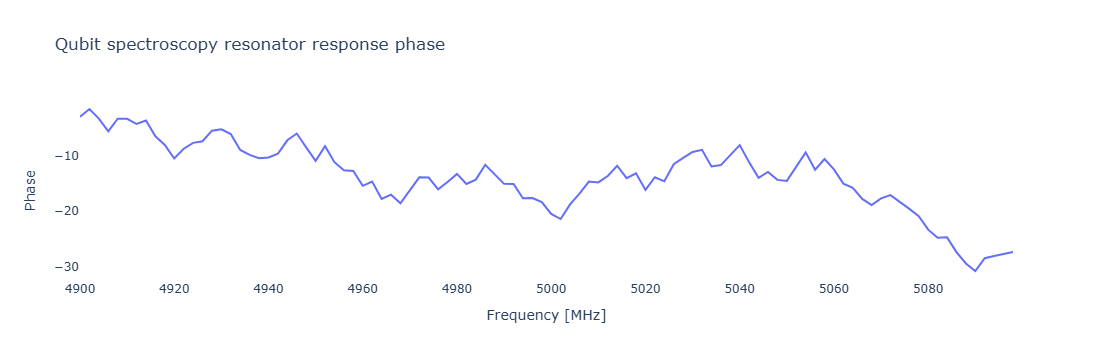

<IPython.core.display.JSON object>


Frequency sweep completed!
Data shape: (100,)
Frequency guess: 4988.00 MHz


In [4]:
# Run single-tone frequency spectroscopy
print("Running single-tone frequency spectroscopy...")

freq_spec = QubitSpectroscopyFrequency(
    dut_qubit=qubit,
    start=4900.0,  # Start frequency (MHz)
    stop=5100.0,   # Stop frequency (MHz)
    step=2.0,      # Step size (MHz)
    num_avs=1000,  # Number of averages
    amp=0.1,       # Drive amplitude
    mp_width=1.0   # Measurement pulse width (us)
)

# The experiment runs automatically in the constructor
# Results are stored in freq_spec.result

print(f"\nFrequency sweep completed!")
print(f"Data shape: {freq_spec.result['Magnitude'].shape}")
print(f"Frequency guess: {freq_spec.frequency_guess:.2f} MHz")

Peak frequency: 4988.00 MHz
Peak magnitude: 43.8292
FWHM: 188.00 MHz


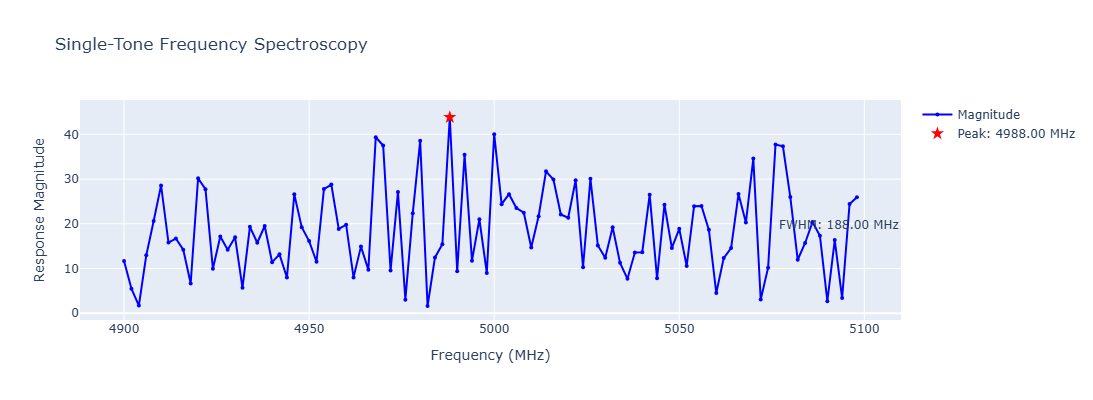

In [5]:
# Find the peak in the frequency sweep
magnitude = freq_spec.result['Magnitude']
frequencies = freq_spec.freq_arr

peak_idx = np.argmax(magnitude)
peak_freq = frequencies[peak_idx]
peak_mag = magnitude[peak_idx]

# Calculate FWHM (Full Width at Half Maximum)
half_max = peak_mag / 2
indices = np.where(magnitude > half_max)[0]
if len(indices) > 1:
    fwhm = frequencies[indices[-1]] - frequencies[indices[0]]
else:
    fwhm = 0

print(f"Peak frequency: {peak_freq:.2f} MHz")
print(f"Peak magnitude: {peak_mag:.4f}")
print(f"FWHM: {fwhm:.2f} MHz")

# Create a detailed plot
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=frequencies,
    y=magnitude,
    mode='lines+markers',
    name='Magnitude',
    line=dict(color='blue', width=2),
    marker=dict(size=4)
))

# Add peak marker
fig.add_trace(go.Scatter(
    x=[peak_freq],
    y=[peak_mag],
    mode='markers',
    name=f'Peak: {peak_freq:.2f} MHz',
    marker=dict(color='red', size=10, symbol='star')
))

# Add FWHM region
if fwhm > 0:
    fig.add_hrect(
        y0=0, y1=half_max,
        x0=frequencies[indices[0]], x1=frequencies[indices[-1]],
        fillcolor='green', opacity=0.2,
        annotation_text=f"FWHM: {fwhm:.2f} MHz"
    )

fig.update_layout(
    title='Single-Tone Frequency Spectroscopy',
    xaxis_title='Frequency (MHz)',
    yaxis_title='Response Magnitude',
    width=800,
    height=400,
    showlegend=True
)

fig.show()

## Part 2: Amplitude-Frequency 2D Spectroscopy

Next, we perform a 2D sweep of both amplitude and frequency to study power broadening
and find the optimal drive amplitude for coherent control.

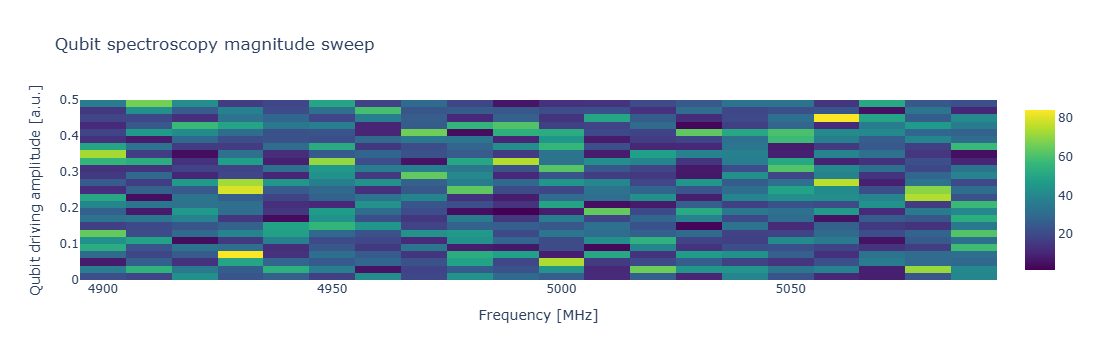

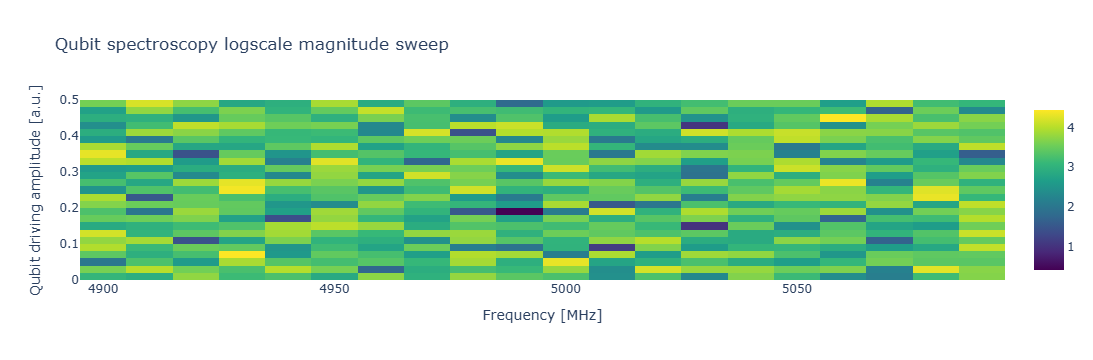

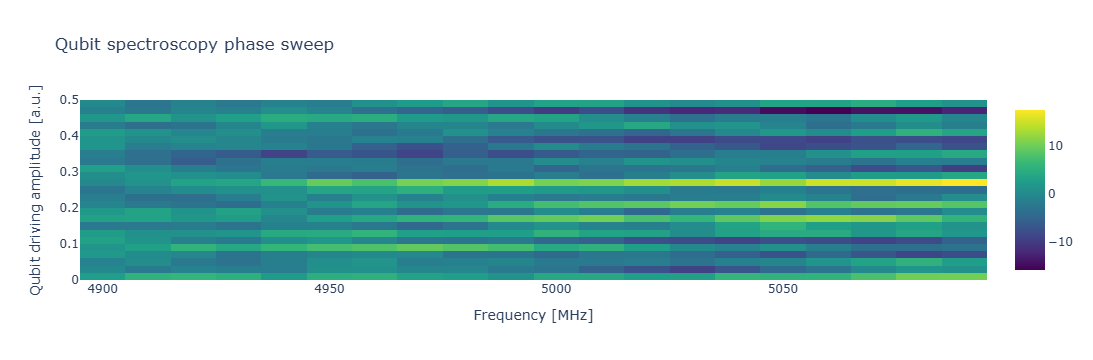

<IPython.core.display.JSON object>

2D Spectroscopy completed. Data shape: (25, 20)


In [6]:
# 2D Amplitude-Frequency Spectroscopy
exp_2d = QubitSpectroscopyAmplitudeFrequency(
    dut_qubit=qubit,
    start=4900.0,
    stop=5100.0,
    step=10.0,
    qubit_amp_start=0.01,
    qubit_amp_stop=0.5,
    qubit_amp_step=0.02,
    num_avs=500
)

print(f"2D Spectroscopy completed. Data shape: {exp_2d.result['Magnitude'].shape}")

### Analyze 2D Amplitude-Frequency Results

Optimal amplitude: 0.070
Optimal frequency: 4930.00 MHz
Peak response: 84.2417


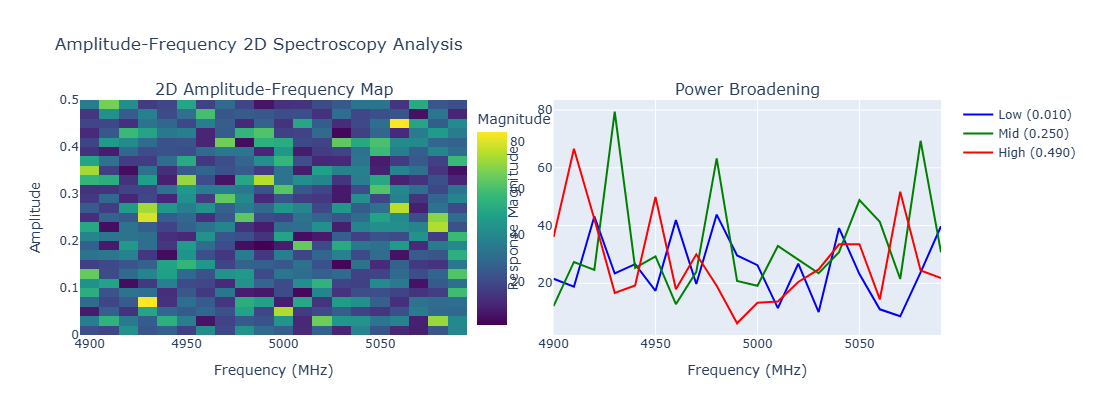


Linewidth at low power: 170.00 MHz
Linewidth at high power: 170.00 MHz
Power broadening factor: 1.0


In [7]:
# Find the optimal amplitude (where response is maximum)
magnitude_2d = exp_2d.result['Magnitude']
peak_idx_2d = np.unravel_index(np.argmax(magnitude_2d), magnitude_2d.shape)
optimal_amp = exp_2d.amp_arr[peak_idx_2d[0]]
optimal_freq = exp_2d.freq_arr[peak_idx_2d[1]]
optimal_amp_idx = peak_idx_2d[0]  # Save for later use

print(f"Optimal amplitude: {optimal_amp:.3f}")
print(f"Optimal frequency: {optimal_freq:.2f} MHz")
print(f"Peak response: {magnitude_2d[peak_idx_2d]:.4f}")

# Extract power broadening data
# Get frequency profile at different amplitudes
low_power_idx = 0
mid_power_idx = len(exp_2d.amp_arr) // 2
high_power_idx = -1

fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=('2D Amplitude-Frequency Map', 'Power Broadening'),
    specs=[[{'type': 'heatmap'}, {'type': 'scatter'}]]
)

# 2D heatmap
fig.add_trace(
    go.Heatmap(
        x=exp_2d.freq_arr,
        y=exp_2d.amp_arr,
        z=magnitude_2d,
        colorscale='Viridis',
        colorbar=dict(title='Magnitude', x=0.45)
    ),
    row=1, col=1
)

# Power broadening curves
for idx, (amp_idx, name, color) in enumerate([
    (low_power_idx, f'Low ({exp_2d.amp_arr[low_power_idx]:.3f})', 'blue'),
    (mid_power_idx, f'Mid ({exp_2d.amp_arr[mid_power_idx]:.3f})', 'green'),
    (high_power_idx, f'High ({exp_2d.amp_arr[high_power_idx]:.3f})', 'red')
]):
    fig.add_trace(
        go.Scatter(
            x=exp_2d.freq_arr,
            y=magnitude_2d[amp_idx, :],
            mode='lines',
            name=name,
            line=dict(color=color, width=2)
        ),
        row=1, col=2
    )

fig.update_xaxes(title_text="Frequency (MHz)", row=1, col=1)
fig.update_yaxes(title_text="Amplitude", row=1, col=1)
fig.update_xaxes(title_text="Frequency (MHz)", row=1, col=2)
fig.update_yaxes(title_text="Response Magnitude", row=1, col=2)

fig.update_layout(
    title='Amplitude-Frequency 2D Spectroscopy Analysis',
    width=1200,
    height=400,
    showlegend=True
)

fig.show()

# Calculate and display linewidth vs power
linewidths = []
for amp_idx in range(len(exp_2d.amp_arr)):
    profile = magnitude_2d[amp_idx, :]
    half_max = np.max(profile) / 2
    indices = np.where(profile > half_max)[0]
    if len(indices) > 1:
        linewidth = exp_2d.freq_arr[indices[-1]] - exp_2d.freq_arr[indices[0]]
    else:
        linewidth = 0
    linewidths.append(linewidth)

print(f"\nLinewidth at low power: {linewidths[0]:.2f} MHz")
print(f"Linewidth at high power: {linewidths[-1]:.2f} MHz")
print(f"Power broadening factor: {linewidths[-1]/linewidths[0] if linewidths[0] > 0 else 'N/A'}")

## Part 3: Two-Tone Spectroscopy

Finally, we perform two-tone spectroscopy with simultaneous frequency sweeps.
This reveals multi-photon transitions, coupling effects, and AC Stark shifts.

Running two-tone spectroscopy...


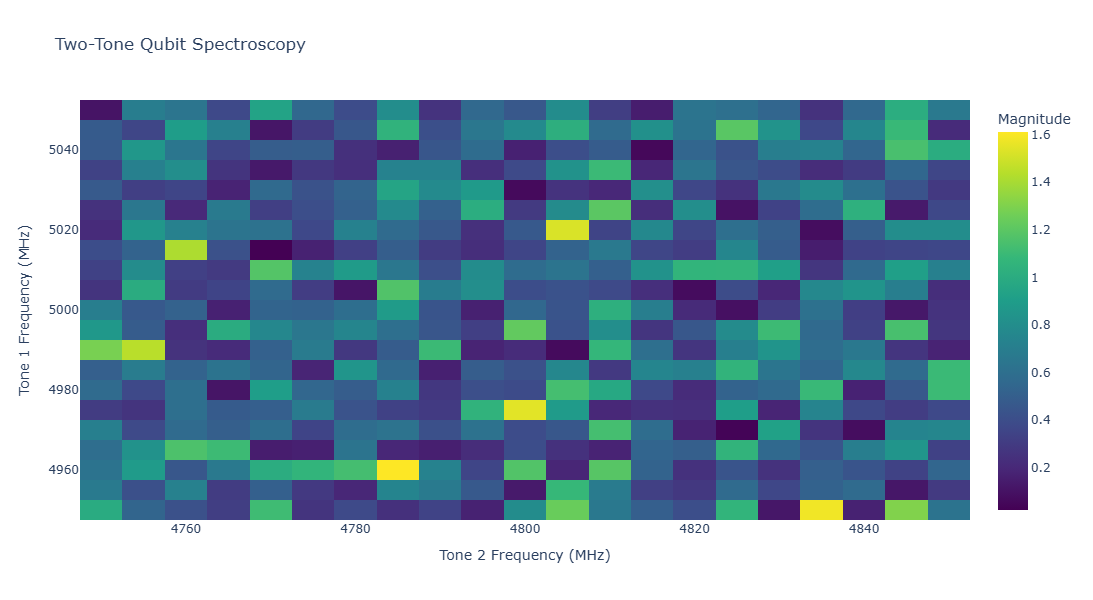

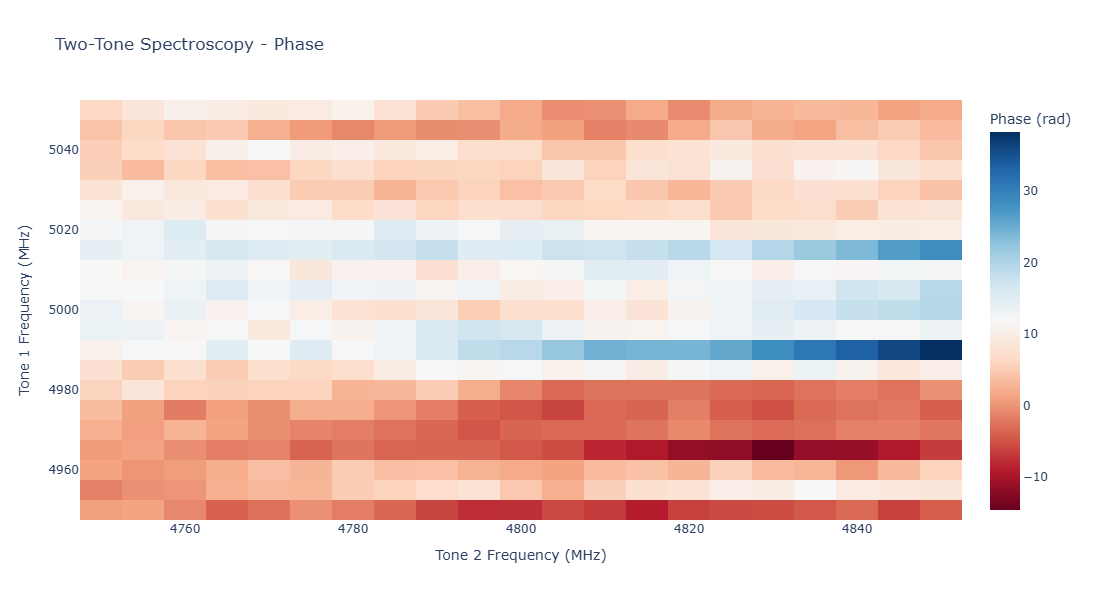

<IPython.core.display.JSON object>


Two-tone spectroscopy completed!
Data shape: (21, 21)
Peak found at: Tone1=4960.00 MHz, Tone2=4785.00 MHz
Peak magnitude: 1.6112


In [8]:
# Run two-tone spectroscopy
print("Running two-tone spectroscopy...")

two_tone_spec = TwoToneQubitSpectroscopy(
    dut_qubit=qubit,
    tone1_start=4950.0,  # Tone 1 frequency start (MHz)
    tone1_stop=5050.0,   # Tone 1 frequency stop (MHz)
    tone1_step=5.0,      # Tone 1 step (MHz)
    tone1_amp=0.1,       # Tone 1 amplitude
    tone2_start=4750.0,  # Tone 2 frequency start (MHz)
    tone2_stop=4850.0,   # Tone 2 frequency stop (MHz)
    tone2_step=5.0,      # Tone 2 step (MHz)
    tone2_amp=0.1,       # Tone 2 amplitude
    same_channel=False,  # Use different channels
    num_avs=500,         # Number of averages
    mp_width=1.0         # Measurement pulse width (us)
)

print(f"\nTwo-tone spectroscopy completed!")
print(f"Data shape: {two_tone_spec.result['Magnitude'].shape}")

# Find peaks
peaks = two_tone_spec.find_peaks()
print(f"Peak found at: Tone1={peaks['peak_freq1']:.2f} MHz, Tone2={peaks['peak_freq2']:.2f} MHz")
print(f"Peak magnitude: {peaks['peak_magnitude']:.4f}")

### Analyze Two-Tone Results

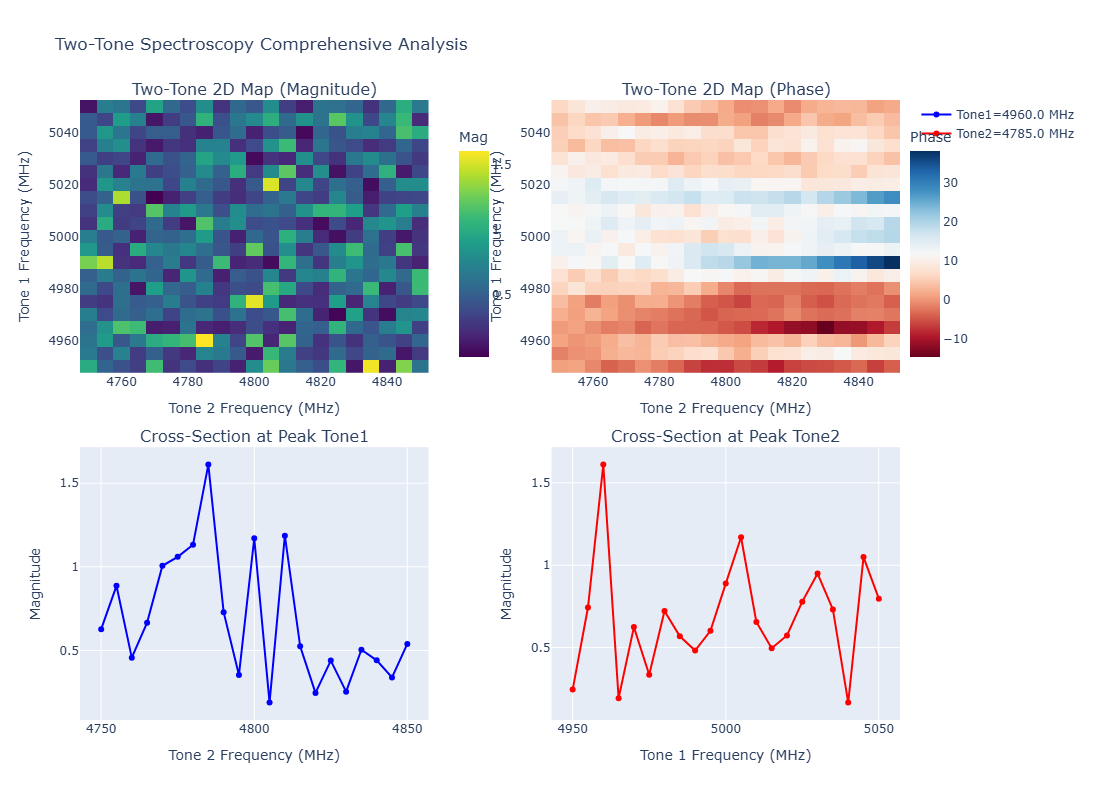

In [9]:
# Get cross-sections for detailed analysis
cross1 = two_tone_spec.get_cross_section(axis='freq1')
cross2 = two_tone_spec.get_cross_section(axis='freq2')

# Create comprehensive two-tone analysis plot
fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=(
        'Two-Tone 2D Map (Magnitude)',
        'Two-Tone 2D Map (Phase)',
        'Cross-Section at Peak Tone1',
        'Cross-Section at Peak Tone2'
    ),
    specs=[[{'type': 'heatmap'}, {'type': 'heatmap'}],
           [{'type': 'scatter'}, {'type': 'scatter'}]],
    vertical_spacing=0.12,
    horizontal_spacing=0.15
)

# Magnitude heatmap
fig.add_trace(
    go.Heatmap(
        x=two_tone_spec.freq2_arr,
        y=two_tone_spec.freq1_arr,
        z=two_tone_spec.result['Magnitude'],
        colorscale='Viridis',
        colorbar=dict(title='Mag', x=0.45, y=0.77, len=0.4)
    ),
    row=1, col=1
)

# Phase heatmap
phase_unwrapped = np.unwrap(np.unwrap(two_tone_spec.result['Phase'], axis=0), axis=1)
fig.add_trace(
    go.Heatmap(
        x=two_tone_spec.freq2_arr,
        y=two_tone_spec.freq1_arr,
        z=phase_unwrapped,
        colorscale='RdBu',
        colorbar=dict(title='Phase', x=1.0, y=0.77, len=0.4)
    ),
    row=1, col=2
)

# Cross-section 1
fig.add_trace(
    go.Scatter(
        x=cross1['frequencies'],
        y=cross1['magnitude'],
        mode='lines+markers',
        name=f"Tone1={cross1['slice_freq']:.1f} MHz",
        line=dict(color='blue', width=2)
    ),
    row=2, col=1
)

# Cross-section 2
fig.add_trace(
    go.Scatter(
        x=cross2['frequencies'],
        y=cross2['magnitude'],
        mode='lines+markers',
        name=f"Tone2={cross2['slice_freq']:.1f} MHz",
        line=dict(color='red', width=2)
    ),
    row=2, col=2
)

# Update axes labels
fig.update_xaxes(title_text="Tone 2 Frequency (MHz)", row=1, col=1)
fig.update_yaxes(title_text="Tone 1 Frequency (MHz)", row=1, col=1)
fig.update_xaxes(title_text="Tone 2 Frequency (MHz)", row=1, col=2)
fig.update_yaxes(title_text="Tone 1 Frequency (MHz)", row=1, col=2)
fig.update_xaxes(title_text="Tone 2 Frequency (MHz)", row=2, col=1)
fig.update_yaxes(title_text="Magnitude", row=2, col=1)
fig.update_xaxes(title_text="Tone 1 Frequency (MHz)", row=2, col=2)
fig.update_yaxes(title_text="Magnitude", row=2, col=2)

fig.update_layout(
    title='Two-Tone Spectroscopy Comprehensive Analysis',
    width=1000,
    height=800,
    showlegend=True
)

fig.show()

## Comparison: All Three Spectroscopy Methods

Let's compare the results from all three spectroscopy techniques side by side.

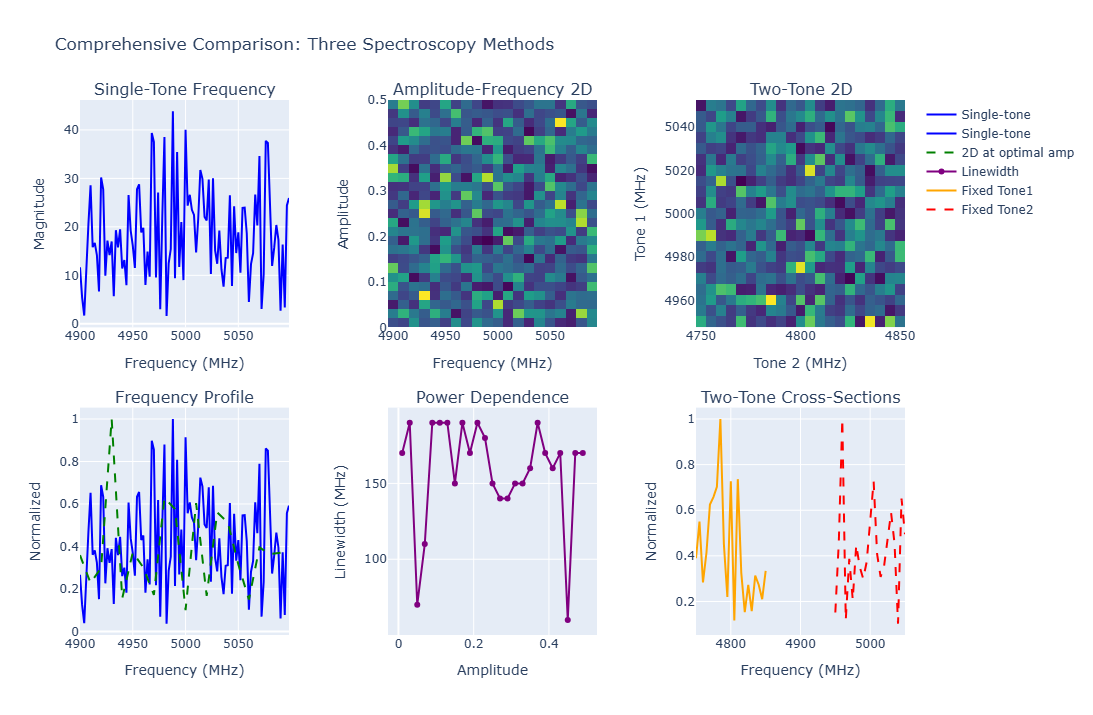

In [10]:
# Create comparison plot
fig = make_subplots(
    rows=2, cols=3,
    subplot_titles=(
        'Single-Tone Frequency',
        'Amplitude-Frequency 2D',
        'Two-Tone 2D',
        'Frequency Profile',
        'Power Dependence',
        'Two-Tone Cross-Sections'
    ),
    specs=[[{'type': 'scatter'}, {'type': 'heatmap'}, {'type': 'heatmap'}],
           [{'type': 'scatter'}, {'type': 'scatter'}, {'type': 'scatter'}]],
    vertical_spacing=0.15,
    horizontal_spacing=0.12
)

# Row 1, Col 1: Single-tone frequency sweep
fig.add_trace(
    go.Scatter(
        x=freq_spec.freq_arr,
        y=freq_spec.result['Magnitude'],
        mode='lines',
        name='Single-tone',
        line=dict(color='blue', width=2)
    ),
    row=1, col=1
)

# Row 1, Col 2: Amplitude-frequency 2D map
fig.add_trace(
    go.Heatmap(
        x=exp_2d.freq_arr,
        y=exp_2d.amp_arr,
        z=exp_2d.result['Magnitude'],
        colorscale='Viridis',
        showscale=False
    ),
    row=1, col=2
)

# Row 1, Col 3: Two-tone 2D map
fig.add_trace(
    go.Heatmap(
        x=two_tone_spec.freq2_arr,
        y=two_tone_spec.freq1_arr,
        z=two_tone_spec.result['Magnitude'],
        colorscale='Viridis',
        showscale=False
    ),
    row=1, col=3
)

# Row 2, Col 1: Compare frequency profiles
# Normalize for comparison
single_tone_norm = freq_spec.result['Magnitude'] / np.max(freq_spec.result['Magnitude'])
amp_freq_profile = exp_2d.result['Magnitude'][optimal_amp_idx, :]
amp_freq_norm = amp_freq_profile / np.max(amp_freq_profile)

fig.add_trace(
    go.Scatter(
        x=freq_spec.freq_arr,
        y=single_tone_norm,
        mode='lines',
        name='Single-tone',
        line=dict(color='blue', width=2)
    ),
    row=2, col=1
)

fig.add_trace(
    go.Scatter(
        x=exp_2d.freq_arr,
        y=amp_freq_norm,
        mode='lines',
        name='2D at optimal amp',
        line=dict(color='green', width=2, dash='dash')
    ),
    row=2, col=1
)

# Row 2, Col 2: Linewidth vs amplitude
fig.add_trace(
    go.Scatter(
        x=exp_2d.amp_arr,
        y=linewidths,
        mode='lines+markers',
        name='Linewidth',
        line=dict(color='purple', width=2),
        marker=dict(size=6)
    ),
    row=2, col=2
)

# Row 2, Col 3: Two-tone cross-sections
fig.add_trace(
    go.Scatter(
        x=cross1['frequencies'],
        y=cross1['magnitude'] / np.max(cross1['magnitude']),
        mode='lines',
        name='Fixed Tone1',
        line=dict(color='orange', width=2)
    ),
    row=2, col=3
)

fig.add_trace(
    go.Scatter(
        x=cross2['frequencies'],
        y=cross2['magnitude'] / np.max(cross2['magnitude']),
        mode='lines',
        name='Fixed Tone2',
        line=dict(color='red', width=2, dash='dash')
    ),
    row=2, col=3
)

# Update axes
fig.update_xaxes(title_text="Frequency (MHz)", row=1, col=1)
fig.update_yaxes(title_text="Magnitude", row=1, col=1)
fig.update_xaxes(title_text="Frequency (MHz)", row=1, col=2)
fig.update_yaxes(title_text="Amplitude", row=1, col=2)
fig.update_xaxes(title_text="Tone 2 (MHz)", row=1, col=3)
fig.update_yaxes(title_text="Tone 1 (MHz)", row=1, col=3)
fig.update_xaxes(title_text="Frequency (MHz)", row=2, col=1)
fig.update_yaxes(title_text="Normalized", row=2, col=1)
fig.update_xaxes(title_text="Amplitude", row=2, col=2)
fig.update_yaxes(title_text="Linewidth (MHz)", row=2, col=2)
fig.update_xaxes(title_text="Frequency (MHz)", row=2, col=3)
fig.update_yaxes(title_text="Normalized", row=2, col=3)

fig.update_layout(
    title='Comprehensive Comparison: Three Spectroscopy Methods',
    width=1400,
    height=700,
    showlegend=True
)

fig.show()

## Summary and Key Insights

Let's summarize the key findings from all three spectroscopy experiments.

In [11]:
print("="*60)
print("COMPREHENSIVE SPECTROSCOPY RESULTS SUMMARY")
print("="*60)

print("\n1. SINGLE-TONE FREQUENCY SPECTROSCOPY")
print("-" * 40)
print(f"   Resonance frequency: {freq_spec.frequency_guess:.2f} MHz")
print(f"   Peak magnitude: {np.max(freq_spec.result['Magnitude']):.4f}")
print(f"   FWHM: {fwhm:.2f} MHz")
print(f"   Q-factor: {freq_spec.frequency_guess/fwhm if fwhm > 0 else 'N/A'}")

print("\n2. AMPLITUDE-FREQUENCY 2D SPECTROSCOPY")
print("-" * 40)
print(f"   Optimal frequency: {optimal_freq:.2f} MHz")
print(f"   Optimal amplitude: {optimal_amp:.3f}")
print(f"   Peak response: {np.max(exp_2d.result['Magnitude']):.4f}")
print(f"   Power broadening factor: {linewidths[-1]/linewidths[0] if linewidths[0] > 0 else 'N/A'}")
print(f"   Saturation onset: ~{exp_2d.amp_arr[np.argmax(np.gradient(linewidths))]:.3f}" if len(linewidths) > 1 else "N/A")

print("\n3. TWO-TONE SPECTROSCOPY")
print("-" * 40)
print(f"   Tone 1 peak: {peaks['peak_freq1']:.2f} MHz")
print(f"   Tone 2 peak: {peaks['peak_freq2']:.2f} MHz")
print(f"   Peak magnitude: {peaks['peak_magnitude']:.4f}")
print(f"   Frequency difference: {abs(peaks['peak_freq1'] - peaks['peak_freq2']):.2f} MHz")
print(f"   Sum frequency: {peaks['peak_freq1'] + peaks['peak_freq2']:.2f} MHz")

print("\nKEY OBSERVATIONS:")
print("-" * 40)

# Check consistency across methods
freq_consistency = abs(freq_spec.frequency_guess - optimal_freq) < 10
print(f"✓ Frequency consistency: {'Good' if freq_consistency else 'Check calibration'}")

# Check for power broadening
power_broadening = linewidths[-1] > linewidths[0] * 1.5 if linewidths[0] > 0 else False
print(f"✓ Power broadening observed: {'Yes' if power_broadening else 'No'}")

# Check for two-tone interactions
two_tone_interaction = peaks['peak_magnitude'] > 0.01
print(f"✓ Two-tone interaction detected: {'Yes' if two_tone_interaction else 'Weak/None'}")

print("\nRECOMMENDED PARAMETERS FOR QUBIT CONTROL:")
print("-" * 40)
print(f"   f01 frequency: {optimal_freq:.2f} MHz")
print(f"   π-pulse amplitude (estimate): {optimal_amp:.3f}")
print(f"   Spectroscopy amplitude: {0.1:.3f}")
print(f"   Measurement window: {1.0:.1f} μs")

print("\n" + "="*60)

COMPREHENSIVE SPECTROSCOPY RESULTS SUMMARY

1. SINGLE-TONE FREQUENCY SPECTROSCOPY
----------------------------------------
   Resonance frequency: 4988.00 MHz
   Peak magnitude: 43.8292
   FWHM: 188.00 MHz
   Q-factor: 26.53191489361702

2. AMPLITUDE-FREQUENCY 2D SPECTROSCOPY
----------------------------------------
   Optimal frequency: 4930.00 MHz
   Optimal amplitude: 0.070
   Peak response: 84.2417
   Power broadening factor: 1.0
   Saturation onset: ~0.070

3. TWO-TONE SPECTROSCOPY
----------------------------------------
   Tone 1 peak: 4960.00 MHz
   Tone 2 peak: 4785.00 MHz
   Peak magnitude: 1.6112
   Frequency difference: 175.00 MHz
   Sum frequency: 9745.00 MHz

KEY OBSERVATIONS:
----------------------------------------
✓ Frequency consistency: Check calibration
✓ Power broadening observed: No
✓ Two-tone interaction detected: Yes

RECOMMENDED PARAMETERS FOR QUBIT CONTROL:
----------------------------------------
   f01 frequency: 4930.00 MHz
   π-pulse amplitude (estimate): 

## Advanced Analysis: Extracting Qubit Parameters

From the spectroscopy data, we can extract important qubit parameters.

In [12]:
# Estimate coherence from linewidth
if fwhm > 0:
    # Convert FWHM to T2* (rough estimate)
    T2_star = 1 / (np.pi * fwhm)  # in microseconds
    print(f"Estimated T2*: {T2_star:.2f} μs")

# Analyze anharmonicity from two-tone data if we had f01 and f12 peaks
if 'peaks' in locals() and peaks['peak_freq1'] > 0 and peaks['peak_freq2'] > 0:
    # This is a simplified analysis - actual implementation would need proper f12 identification
    estimated_anharmonicity = abs(peaks['peak_freq1'] - peaks['peak_freq2'])
    print(f"Estimated anharmonicity: {estimated_anharmonicity:.1f} MHz")

# Create a qubit parameter summary card
param_summary = f"""
╔══════════════════════════════════════════╗
║         QUBIT PARAMETER CARD             ║
╠══════════════════════════════════════════╣
║ f01 Frequency:     {optimal_freq:>8.2f} MHz      ║
║ Linewidth (FWHM):  {fwhm:>8.2f} MHz      ║
║ Q-factor:          {(freq_spec.frequency_guess/fwhm if fwhm > 0 else 0):>8.0f}          ║
║ T2* (estimated):   {T2_star if 'T2_star' in locals() else 0:>8.2f} μs       ║
║ Optimal Drive Amp: {optimal_amp:>8.3f}          ║
╚══════════════════════════════════════════╝
"""

print(param_summary)

Estimated T2*: 0.00 μs
Estimated anharmonicity: 175.0 MHz

╔══════════════════════════════════════════╗
║         QUBIT PARAMETER CARD             ║
╠══════════════════════════════════════════╣
║ f01 Frequency:      4930.00 MHz      ║
║ Linewidth (FWHM):    188.00 MHz      ║
║ Q-factor:                27          ║
║ T2* (estimated):       0.00 μs       ║
║ Optimal Drive Amp:    0.070          ║
╚══════════════════════════════════════════╝



## Conclusion

This comprehensive demonstration showcased three essential qubit spectroscopy techniques:

1. **Single-Tone Frequency Spectroscopy**: 
   - Quick identification of qubit resonance frequency
   - Basic linewidth characterization
   - First step in qubit characterization

2. **Amplitude-Frequency 2D Spectroscopy**:
   - Power broadening analysis
   - Optimal drive amplitude determination
   - Saturation behavior study

3. **Two-Tone Spectroscopy**:
   - Multi-photon transition identification
   - Coupling and crosstalk analysis
   - AC Stark shift measurements

Each technique provides unique insights that are crucial for:
- Accurate qubit calibration
- Optimal control pulse design
- Understanding decoherence mechanisms
- Identifying and mitigating crosstalk

The combination of all three methods provides a complete picture of the qubit's spectroscopic properties,
enabling precise quantum control and high-fidelity gate operations.